# Two dimensional FDTD code for constant dielectric materials

In [47]:
"""2D FDTD with YEE-Algorithmus: leapfrog and staggered grid according to 
    Taflove's book
    - in vacuum with Debye material
    - BC: PEC and PML
    - TE-mode

Richard Ciesielski
"""
%load_ext autoreload
%autoreload 2

import numpy
from numpy import pi
import pylab
%matplotlib inline

# Simulation libraries:
import fdtd_core as core
import fdtd_excitations as exc
import fdtd_objects as obj
import fdtd_visualization as vis


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation with a dielectric scatterer

number of nodes : 301 x 258 = 77658 	 time step : 0.0544438894894 	 cycles : 277
simulation time left:  15 fs
simulation time left:  14 fs
simulation time left:  13 fs
simulation time left:  12 fs
simulation time left:  12 fs
simulation time left:  11 fs
simulation time left:  10 fs
simulation time left:  10 fs
simulation time left:  9 fs
simulation time left:  8 fs
simulation time left:  8 fs
simulation time left:  7 fs
simulation time left:  6 fs
simulation time left:  5 fs
simulation time left:  5 fs
simulation time left:  4 fs
simulation time left:  3 fs
simulation time left:  3 fs
simulation time left:  2 fs
simulation time left:  1 fs
simulation time left:  0 fs
simulation time left:  0 fs
done


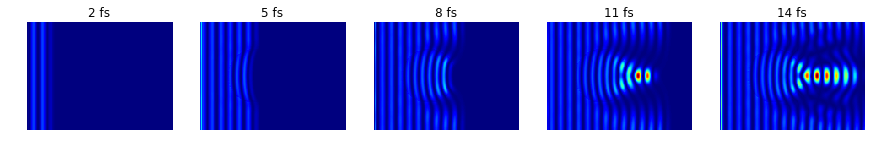

In [50]:
# create a mesh:
lengthx = 7.
lengthy = 6.
Nx = 301                            # number of nodes for the E-field
dx = lengthx / (Nx - 1)
Ny =  int(lengthy / dx + 1)
lengthy = (Ny - 1) * dx             # adjust the length

# produce a staggered grid with NxN nodes:
grid = core.staggered_grid_2D_simple(lengthx, lengthy, Nx, Ny)

# add PMLs:
grid.addPML(1.5, "right", 11., "full")
grid.addPML(1.5, "left", 11., "full")
grid.addPML(1.5, "up", 11.)
grid.addPML(1.5, "down", 11.)

# add scatterer:
obj.addDielectricCircle(grid, 
    x=3, y=3, R=0.75, n = 1.25)

# add excitation:
excitations = []
excitations.append(exc.PWleft_Exc(H=1, T=0.5/grid.c0, a=1.5))

dt = grid.dt 

t, t_end = 0, 15.1                 # duration of the simulation
cycles = int((t_end - t) / dt)      # total number of cycles
time = numpy.linspace(t, t_end, cycles)

print "number of nodes :",Nx, "x", Ny,"=", Nx*Ny, \
        "\t time step :",dt,  "\t cycles :", cycles

# list of snapshot times
t_list = numpy.linspace(t, t_end-2*dt, 6)
S_list = []

for i in xrange(cycles):             # main loop
    grid.Ex, grid.Ey, grid.Hz = \
            core.CalculationStep_simple(grid, t, excitations)
    
    # keep a snapshot
    for t0 in t_list:
        if abs(t-t0) < dt / 2:
            # calculate the actual absolute value of the Poynting vector:
            S = numpy.sqrt((grid.Ey* grid.Hz[:, :-1])**2 + 
                                 (grid.Ex[:-1, :-1]  * grid.Hz[:, :-1])**2)
            S_list.append(S)
    
    # print progress:
    if cycles > 20:
        if i % int(cycles / 20) == 0: print "simulation time left: ", int(t_end - t), "fs"
            
    t = t + dt

print "done"

# now plot the snapshots
n = len(S_list)

norm = 0.
for i in range(n):
    if norm < S_list[i].max():
        norm = S_list[i].max()

pylab.figure(figsize=(15,3))
for i in range(1,n):
    pylab.subplot(1,n-1,i)
    vis.plot_matrix(S_list[i], grid, 0)
    pylab.clim(0, norm)
    pylab.axis('off')
    pylab.title(str(int(t_list[i])) +' fs')
